In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)


Tensorflow 2.2.0


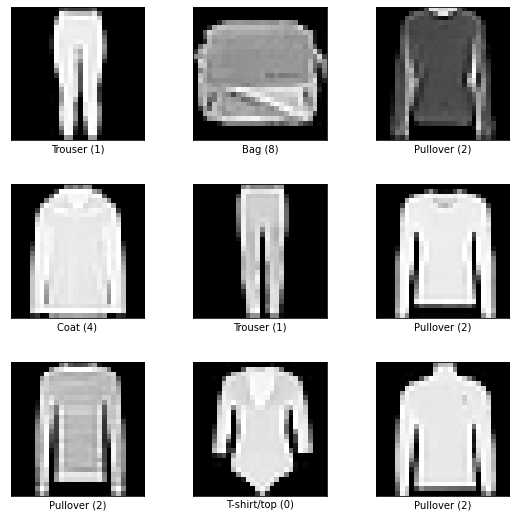

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [2]:
ds_train, ds_info = tfds.load('fashion_mnist', split='train', shuffle_files=True, with_info=True)
fig = tfds.show_examples(ds_info, ds_train)
ds_info

In [3]:
batch_size = 200
image_shape = (28, 28, 1)

def preprocess(features):
    image = tf.image.resize(features['image'], image_shape[:2])    
    image = tf.cast(image, tf.float32)
    image = (image-127.5)/127.5
    return image


ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size).repeat()

train_num = ds_info.splits['train'].num_examples
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

300


In [4]:
class GAN():
    def __init__(self, generator, discriminator):        
        # discriminator
        self.D = discriminator
        self.G = generator

        self.bce = tf.keras.losses.BinaryCrossentropy()
        self.d_loss = {}
        self.g_loss = {}
        self.accuracy = {}        
        self.g_gradients = []

    def discriminator_loss(self, pred_fake, pred_real):
        real_loss = self.bce(tf.ones_like(pred_real), pred_real)
        fake_loss = self.bce(tf.zeros_like(pred_fake), pred_fake)
        
        d_loss = 0.5*(real_loss + fake_loss)
        return d_loss
    
    def generator_loss(self, pred_fake):
        g_loss = self.bce(tf.ones_like(pred_fake), pred_fake)
        return g_loss
    
    def train_step(self, g_input, real_input):

        with tf.GradientTape() as g_tape,\
             tf.GradientTape() as d_tape:
            # Feed forward
            fake_input = self.G(g_input)

            pred_fake = self.D(fake_input)
            pred_real = self.D(real_input)

            # Calculate losses
            d_loss = self.discriminator_loss(pred_fake, pred_real)
            g_loss = self.generator_loss(pred_fake)
            
            # Accuracy
            fake_accuracy = tf.math.reduce_mean(binary_accuracy(tf.zeros_like(pred_fake), pred_fake))
            real_accuracy = tf.math.reduce_mean(binary_accuracy(tf.ones_like(pred_real), pred_real))
            
            # backprop gradients
            gradient_g = g_tape.gradient(g_loss, self.G.trainable_variables)
            gradient_d = d_tape.gradient(d_loss, self.D.trainable_variables)
            
            gradient_g_l1_norm = [tf.norm(gradient).numpy() for gradient in gradient_g]
            self.g_gradients.append(gradient_g_l1_norm) 
            # update weights
            self.G_optimizer.apply_gradients(zip(gradient_g, self.G.trainable_variables))
            self.D_optimizer.apply_gradients(zip(gradient_d, self.D.trainable_variables))


        return g_loss, d_loss, fake_accuracy, real_accuracy
    
    def train(self, data_generator, 
                    z_generator,
                    g_optimizer, d_optimizer,
                    steps, interval=100):
        self.D_optimizer = d_optimizer
        self.G_optimizer = g_optimizer          
        val_g_input = next(z_generator)
        for i in range(steps):
            g_input = next(z_generator)
            real_input = next(data_generator)
            
            g_loss, d_loss, fake_accuracy, real_accuracy = self.train_step(g_input, real_input)
            self.d_loss[i] = d_loss.numpy()
            self.g_loss[i] = g_loss.numpy()
            self.accuracy[i] = 0.5*(fake_accuracy.numpy() + real_accuracy.numpy())
            if i%interval == 0:
                msg = "Step {}: d_loss {:.4f} g_loss {:.4f} Accuracy. real : {:.3f} fake : {:.3f}"\
                .format(i, d_loss, g_loss, real_accuracy, fake_accuracy)
                print(msg)
                
                fake_images = self.G(val_g_input)
                self.plot_images(fake_images)

    def plot_images(self, images):
        pass

In [5]:
class DCGAN(GAN):
    def __init__(self, z_dim, input_shape):
        
        discriminator = self.Discriminator(input_shape)
        generator = self.Generator(z_dim)
        
        GAN.__init__(self, generator, discriminator)
        
    def Discriminator(self, input_shape): 

        model = tf.keras.Sequential(name='Discriminator') 
        model.add(layers.Input(shape=input_shape)) 

        model.add(layers.Conv2D(32, 3, strides=(2,2), padding='same'))
        model.add(layers.BatchNormalization(momentum=0.9))
        model.add(layers.LeakyReLU(0.2)) 
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(64, 3, strides=(2,2), padding='same')) 
        model.add(layers.BatchNormalization(momentum=0.9)) 
        model.add(layers.LeakyReLU(0.2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Flatten()) 
        model.add(layers.Dense(1, activation='sigmoid')) 

        return model 

    def Generator(self, z_dim): 

        model = tf.keras.Sequential(name='Generator') 
        model.add(layers.Input(shape=[z_dim])) 

        model.add(layers.Dense(7*7*64))        
        model.add(layers.BatchNormalization(momentum=0.9)) 
        model.add(layers.ReLU())
        model.add(layers.Reshape((7,7,64))) 

        model.add(layers.Conv2D(64, 3, padding='same')) 
        model.add(layers.BatchNormalization(momentum=0.9)) 
        model.add(layers.ReLU())         
        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))

        model.add(layers.Conv2D(32, 3, padding='same')) 
        model.add(layers.ReLU()) 
        model.add(layers.UpSampling2D((2,2), interpolation="bilinear")) 

        model.add(layers.Conv2D(image_shape[-1], 3, padding='same', activation='tanh')) 

        return model     
    
    def plot_images(self, images):   
        grid_row = 1
        grid_col = 8
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
        for col in range(grid_col):
            axarr[col].imshow((images[col,:,:,0]+1)/2, cmap='gray')
            axarr[col].axis('off') 
        plt.show()

z_dim = 100


def z_generator(batch_size, z_dim):
    while True:
         yield tf.random.normal((batch_size, z_dim))        
            
z_gen = z_generator(batch_size, z_dim)


#gan.D.summary()
#gan.G.summary()

In [6]:
gan = DCGAN(z_dim, image_shape)

In [7]:
gan.D.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)        

In [8]:
gan.G.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_2 (Batch (None, 3136)              12544     
_________________________________________________________________
re_lu (ReLU)                 (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 64)          0 

Step 0: d_loss 0.6914 g_loss 0.6935 Accuracy. real : 0.480 fake : 0.540


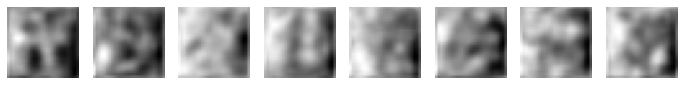

Step 600: d_loss 0.3068 g_loss 2.4972 Accuracy. real : 0.690 fake : 1.000


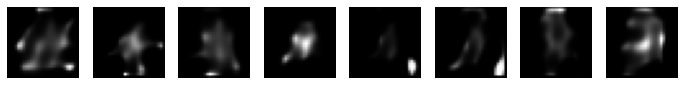

Step 1200: d_loss 0.5011 g_loss 0.7651 Accuracy. real : 0.915 fake : 0.560


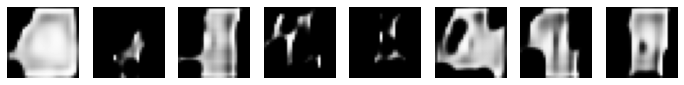

Step 1800: d_loss 1.2109 g_loss 0.2844 Accuracy. real : 0.860 fake : 0.135


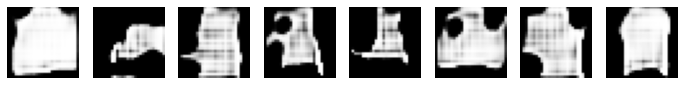

Step 2400: d_loss 0.3661 g_loss 1.4371 Accuracy. real : 0.825 fake : 0.920


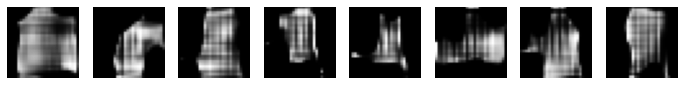

Step 3000: d_loss 0.5687 g_loss 1.1782 Accuracy. real : 0.505 fake : 0.890


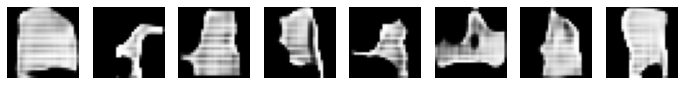

Step 3600: d_loss 0.5171 g_loss 1.0554 Accuracy. real : 0.740 fake : 0.725


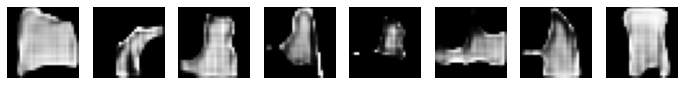

Step 4200: d_loss 0.5977 g_loss 0.8978 Accuracy. real : 0.685 fake : 0.615


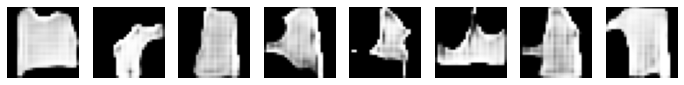

Step 4800: d_loss 0.5096 g_loss 0.8416 Accuracy. real : 0.875 fake : 0.645


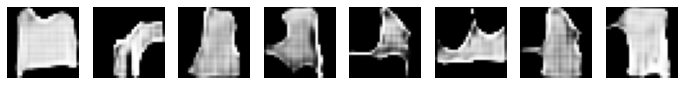

Step 5400: d_loss 0.5307 g_loss 1.6229 Accuracy. real : 0.430 fake : 0.985


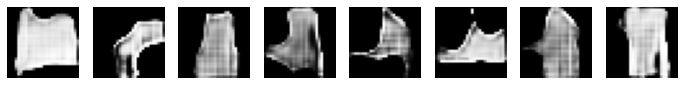

Step 6000: d_loss 0.4710 g_loss 1.1526 Accuracy. real : 0.700 fake : 0.930


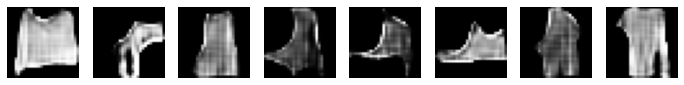

Step 6600: d_loss 0.5108 g_loss 1.0246 Accuracy. real : 0.765 fake : 0.720


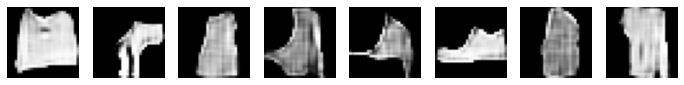

Step 7200: d_loss 0.5031 g_loss 1.2213 Accuracy. real : 0.615 fake : 0.955


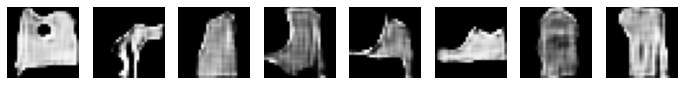

In [9]:
gan.train(iter(ds_train), z_gen, 
          RMSprop(3e-4), RMSprop(3e-4),
          25*train_steps_per_epoch, 
          2*train_steps_per_epoch)

Text(0.5, 0, 'Steps')

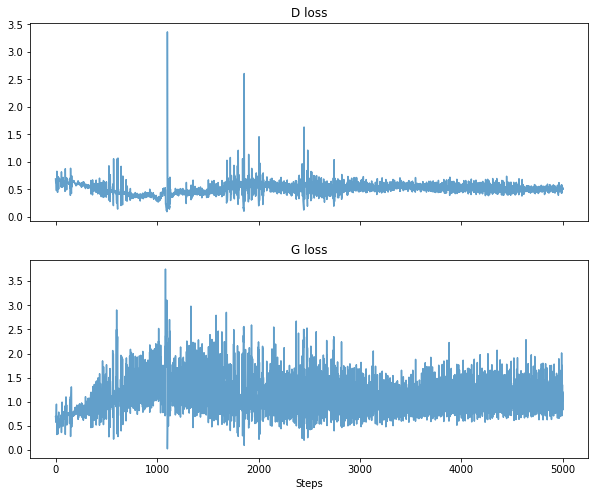

In [14]:
#plt.figure(figsize=(10,6))
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.set_figwidth(10)
fig.set_figheight(8)
ax1.plot(list(gan.d_loss.values())[:5000], label='D loss', alpha=0.7)
ax1.set_title("D loss")
ax2.plot(list(gan.g_loss.values())[:5000], label='G loss', alpha=0.7)
ax2.set_title("G loss")
#ax3.plot([grad[0] for grad in gan.g_gradients], label='G loss', alpha=0.7)
#ax3.set_title("Gradient")

plt.xlabel('Steps')


# MNIST

In [22]:
ds_train, ds_info = tfds.load('mnist', split='train', shuffle_files=True, with_info=True)
ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size).repeat()


In [ ]:
mnist_gan = DCGAN(z_dim, image_shape)

mnist_gan.train(iter(ds_train), z_gen, 
          RMSprop(2e-4), RMSprop(2e-4),
          10*train_steps_per_epoch, 
          1*train_steps_per_epoch)